# ResNet usando PyTorch Lightning

- Entrenamiento de Dog Emotion



## Cargar base de datos


In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("danielshanbalico/dog-emotion")

print("Path to dataset files:", path)

100%|██████████| 155M/155M [00:09<00:00, 17.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/danielshanbalico/dog-emotion/versions/1


## Cargar Librerias

In [2]:
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
import time
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torchmetrics

from collections import Counter
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import TQDMProgressBar, RichProgressBar

import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np



## Preprocesamiento

In [4]:
df = pd.read_csv("imagenes_procesadas_para_modelamiento.csv")
df.head(2)

,file_name,tensor,label,hash,contiene_perro,subset
0,09dUVMcjCDfOtbeYDQg5Fvu3GPHWJg811.jpg,"tensor([[[0.0039, 0.0118, 0.0000, ..., 0.0039...",angry,4da78b5b3b24c75e9b2fb40c938aab57,True,train
1,0AvKtuzA7LfxnKaO0bey9mQMLnxXad73.jpg,"tensor([[[0.4118, 0.4118, 0.4157, ..., 0.0941...",angry,14822cd502ec2c6a8c320f046a22b7e4,True,train


In [5]:
# Crear la nueva columna 'clase' con el mismo contenido que 'label'
df['clase'] = df['label']

# Codificar 'label' en valores numéricos
df['label'] = df['label'].astype('category').cat.codes

# Mostrar los primeros registros para verificar
df.head()

,file_name,tensor,label,hash,contiene_perro,subset,clase
0,09dUVMcjCDfOtbeYDQg5Fvu3GPHWJg811.jpg,"tensor([[[0.0039, 0.0118, 0.0000, ..., 0.0039...",0,4da78b5b3b24c75e9b2fb40c938aab57,True,train,angry
1,0AvKtuzA7LfxnKaO0bey9mQMLnxXad73.jpg,"tensor([[[0.4118, 0.4118, 0.4157, ..., 0.0941...",0,14822cd502ec2c6a8c320f046a22b7e4,True,train,angry
2,0C5yo7GxMy8lztxNZvSdfEx2gSPRTR701.jpg,"tensor([[[0.0078, 0.0078, 0.0039, ..., 0.0039...",0,10a5f619c8bd0bf549e468c4e333d9fd,False,train,angry
3,0C9jEgFQHsh36W5U2u5CA98lB7C5eX806.jpg,"tensor([[[0.0039, 0.0000, 0.0039, ..., 0.0039...",0,4d7fc66574d4a5c67471c6b7a8b6d604,True,train,angry
4,0RXraPIKC00Dz1qkuMbj8XbuR80g5Z893.jpg,"tensor([[[0.0039, 0.0039, 0.0078, ..., 0.0078...",0,2ed31cdf98d5dc6882cc26b0341e287d,True,train,angry


In [6]:
print(df[['clase', 'label']].drop_duplicates().sort_values('label'))

        clase  label
0       angry      0
998     happy      1
1998  relaxed      2
2998      sad      3


In [7]:

# Ruta ajustada al directorio de las imágenes
dataset_path = os.path.join(path, "Dog Emotion")
dataset_path

'/root/.cache/kagglehub/datasets/danielshanbalico/dog-emotion/versions/1/Dog Emotion'

## Primer Acercamiento Datos

In [8]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
import glob  # Para buscar en subdirectorios


# Transformaciones para imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar imágenes a 128x128 píxeles
    transforms.ToTensor(),         # Convertir imágenes a tensores
    transforms.Normalize((0.5,), (0.5,))  # Normalizar valores de píxeles
])

# Función para encontrar la ruta real de una imagen en subcarpetas
def find_image_path(image_name, root_dir):
    """Busca la imagen en todas las subcarpetas y devuelve la ruta completa."""
    for root, _, files in os.walk(root_dir):
        if image_name in files:
            return os.path.join(root, image_name)
    return None  # Retorna None si no se encuentra

# Clase Dataset personalizada
class CustomDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]["file_name"]
        label = self.df.iloc[idx]["label"]

        # Buscar la imagen en las subcarpetas
        img_path = find_image_path(img_name, self.root_dir)
        if img_path is None:
            raise FileNotFoundError(f"No se encontró la imagen: {img_name}")

        # Cargar imagen
        image = Image.open(img_path).convert("RGB")

        # Aplicar transformaciones
        if self.transform:
            image = self.transform(image)

        return image, label

# Filtrar datos de entrenamiento y prueba
train_df = df[df["subset"] == "train"]
test_df = df[df["subset"] == "test"]

# Crear datasets
train_dataset = CustomDataset(train_df, dataset_path, transform)
test_dataset = CustomDataset(test_df, dataset_path, transform)

# Crear DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = 2

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)



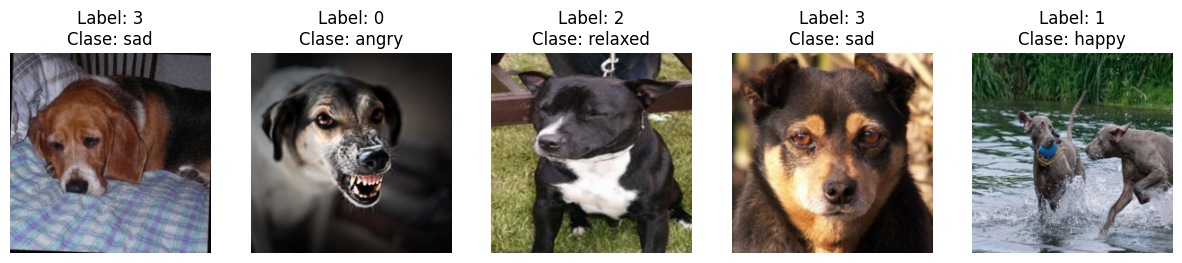

In [9]:
# Obtener un batch de imágenes y labels del train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Obtener los nombres de las clases
label_to_class = dict(zip(train_df['label'], train_df['clase']))
label_to_class = {k: v for k, v in sorted(label_to_class.items())}  # Ordenar por índice

# Mostrar 5 imágenes con sus etiquetas
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    img = images[i].permute(1, 2, 0).numpy()  # Convertir de tensor a numpy
    img = (img * 0.5) + 0.5  # Desnormalizar

    label_num = labels[i].item()
    label_name = label_to_class[label_num]

    axes[i].imshow(img)
    axes[i].set_title(f"Label: {label_num}\nClase: {label_name}")
    axes[i].axis("off")

plt.show()


In [10]:
for images, labels in train_loader:
    print(images.shape)
    print(labels)
    break

torch.Size([32, 3, 224, 224])
tensor([1, 0, 2, 1, 2, 0, 2, 3, 1, 2, 1, 3, 2, 1, 3, 3, 3, 2, 2, 0, 0, 1, 3, 1,
        2, 2, 3, 0, 2, 2, 1, 1], dtype=torch.int8)


## Modelamiento

### Hiperparámetros de la red

In [11]:
BATCH_SIZE = 16
NUM_EPOCHS = 30
LEARNING_RATE = 0.0000001
NUM_WORKERS = 4 # unidades de procesamiento o hilos
CLASES = 4

### DataModule para Lightning

In [12]:
import os
import pandas as pd
import torch
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image

# Transformaciones para imágenes
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Función para encontrar la ruta real de una imagen en subcarpetas
def find_image_path(image_name, root_dir):
    """Busca la imagen en todas las subcarpetas y devuelve la ruta completa."""
    for root, _, files in os.walk(root_dir):
        if image_name in files:
            return os.path.join(root, image_name)
    return None  # Retorna None si no se encuentra

# Dataset personalizado
class DogEmotionDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]["file_name"]
        label = int(self.df.iloc[idx]["label"])  # Asegurar que sea un entero antes de convertirlo en tensor
        label = torch.tensor(label, dtype=torch.long)

        img_path = find_image_path(img_name, self.root_dir)
        if img_path is None:
            raise FileNotFoundError(f"No se encontró la imagen: {img_name}")

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

# DataModule para PyTorch Lightning
class DogEmotionDataModule(pl.LightningDataModule):
    def __init__(self, csv_path, dataset_path, batch_size=32, num_workers=2):
        super().__init__()
        self.csv_path = csv_path
        self.dataset_path = dataset_path
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.df = None  # Definir el dataframe en setup()

    def setup(self, stage=None):
        """Carga el dataset y lo divide en train, validación y test."""
        self.df = pd.read_csv(self.csv_path)

        # Asegurar que label es numérico
        if not pd.api.types.is_integer_dtype(self.df["label"]):
            self.df["label"] = self.df["label"].astype("category").cat.codes

        train_df = self.df[self.df["subset"] == "train"]
        test_df = self.df[self.df["subset"] == "test"]

        self.train_dataset = DogEmotionDataset(train_df, self.dataset_path, transform=train_transform)
        self.test_dataset = DogEmotionDataset(test_df, self.dataset_path, transform=test_transform)

        # Dividir en entrenamiento y validación (90% - 10%)
        train_size = int(0.9 * len(self.train_dataset))
        valid_size = len(self.train_dataset) - train_size
        self.train_dataset, self.valid_dataset = random_split(self.train_dataset, [train_size, valid_size])

        print(f"Entrenamiento: {train_size}, Validación: {valid_size}, Test: {len(self.test_dataset)}")

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.valid_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=False)

# Inicializar el DataModule
data_module = DogEmotionDataModule(csv_path="imagenes_procesadas_para_modelamiento.csv", dataset_path="ruta/dataset")

# Preparar y cargar datos
data_module.setup()

# Obtener los DataLoaders
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()


Entrenamiento: 3236, Validación: 360, Test: 400


In [14]:
# Inicializar el DataModule
csv_path = "imagenes_procesadas_para_modelamiento.csv"
data_module = DogEmotionDataModule(csv_path, dataset_path)

# Preparar y cargar datos
data_module.prepare_data()
data_module.setup()

# Obtener los DataLoaders
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()
test_loader = data_module.test_dataloader()


Entrenamiento: 3236, Validación: 360, Test: 400


In [15]:
360/(3236+360+400)

0.09009009009009009

In [16]:
# Inicialización de DataModule
torch.manual_seed(47)  # Fijar una semilla para reproducibilidad

# Inicializar el DataModule con la nueva clase
data_module =  DogEmotionDataModule(csv_path, dataset_path)

# Preparar los datos (transformaciones y verificaciones)
data_module.prepare_data()

# Configurar el dataset para entrenamiento, validación y prueba
data_module.setup(stage='fit')

Entrenamiento: 3236, Validación: 360, Test: 400


### Importar la arquitectura

In [17]:
pytorch_model = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 65.2MB/s]


Modificamos el numero de clases de salida en resnet18

In [18]:
pytorch_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [20]:
pytorch_model.classifier[6] = nn.Linear(
    in_features=4096,  # Salida de la última capa lineal de VGG16
    out_features=CLASES  # Número de clases en la salida
)

In [21]:
# Arquitectura modifica a FASHION MNIST
pytorch_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Seleccionamos el número de capas que van a re-entrenarse

In [22]:
# Conocer numero de parámetros
for i, param in enumerate(pytorch_model.parameters()):
  i
print(i)


31


In [23]:
limite = int(i*0.10)
limite

3

In [24]:
# Congelar las primeras capas de VGG16
threshold = i-limite  # Ajustar según sea necesario
for i, param in enumerate(pytorch_model.parameters()):
    if i < threshold:
        param.requires_grad = False
    else:
        param.requires_grad = True

In [25]:
20/150

0.13333333333333333

### Definición del Módulo Lightning

In [26]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torchmetrics

class Lightning_CNN(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-4, num_classes=4):
        super().__init__()

        self.save_hyperparameters(ignore=["model"])  # Guarda hiperparámetros sin incluir el modelo

        self.model = model
        self.num_classes = num_classes

        # Definición de métricas para cada grupo de datos
        self.train_acc = torchmetrics.Accuracy(num_classes=self.num_classes, task="multiclass")
        self.valid_acc = torchmetrics.Accuracy(num_classes=self.num_classes, task="multiclass")
        self.test_acc = torchmetrics.Accuracy(num_classes=self.num_classes, task="multiclass")

        self.loss_fn = nn.CrossEntropyLoss()  # Función de pérdida para clasificación

    def forward(self, x):
        return self.model(x)

    # Paso compartido para train, val y test
    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)
        loss = self.loss_fn(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)  # Obtener la clase predicha

        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        # Registrar loss y accuracy en entrenamiento
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.train_acc(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, on_epoch=True, prog_bar=True)

        return loss  # Este valor se pasa al optimizador

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("valid_loss", loss, on_epoch=True, prog_bar=True)
        self.valid_acc(predicted_labels, true_labels)
        self.log("valid_acc", self.valid_acc, on_epoch=True, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer


### Entrenamiento del modelo

In [27]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.progress import TQDMProgressBar

# Definir hiperparámetros
LEARNING_RATE = 1e-4
CLASES = 4  # Cambiar según el número de clases en Dog Emotion

# Inicializar modelo con MobileNetV2 modificado para 4 clases
lightning_model = Lightning_CNN(
    model=pytorch_model,  # Modelo MobileNetV2 ya ajustado
    learning_rate=LEARNING_RATE,
    num_classes=CLASES
)

# Callbacks para entrenamiento
callback_check = ModelCheckpoint(
    save_top_k=1,  # Guardar solo el mejor modelo
    mode="max",
    monitor="valid_acc",  # Se monitorea la métrica de validación
    filename="best-checkpoint",  # Nombre del archivo del mejor modelo
    save_last=True  # Guarda también la última versión del modelo
)

callback_tqdm = TQDMProgressBar(refresh_rate=20)  # Barra de progreso más limpia

early_stop_callback = EarlyStopping(
    monitor="valid_acc",  # Se monitorea valid_acc para detener el entrenamiento
    patience=10,  # Esperar 10 épocas sin mejora antes de detener el entrenamiento
    mode="max"
)

# Logger para registrar métricas en CSV
logger = CSVLogger(
    save_dir="./logs/",
    name="dog-emotion"
)



In [28]:
#  Inicia entrenamiento

trainer = pl.Trainer(max_epochs= NUM_EPOCHS,
                    callbacks=[callback_check, callback_tqdm, early_stop_callback],
                    accelerator="auto",  # Uses GPUs or TPUs if available
                    devices="auto",  # Uses all available GPUs/TPUs if applicable
                    logger=logger,
                    log_every_n_steps=100)

start_time = time.time()
trainer.fit(model = lightning_model, datamodule = data_module)

runtime = (time.time() - start_time) / 60
print(f"Tiempo de entrenamiento en minutos: {runtime:.2f}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Entrenamiento: 3236, Validación: 360, Test: 400


INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | VGG                | 134 M  | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | valid_acc | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
4 | loss_fn   | CrossEntropyLoss   | 0      | train
---------------------------------------------------------
16.8 M    Trainable params
117 M     Non-trainable params
134 M     Total params
537.108   Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


Tiempo de entrenamiento en minutos: 27.99


Non-trainable params:

*   BatchNorm2d Running Statistics: running_mean and running_var in each batch normalization layer.

## Graficamos las curvas de aprendizaje del modelo

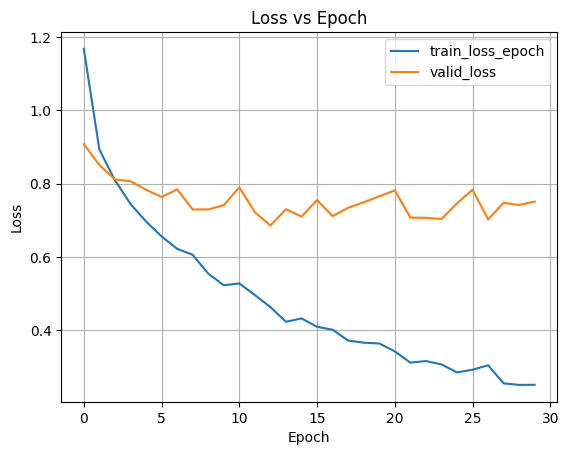

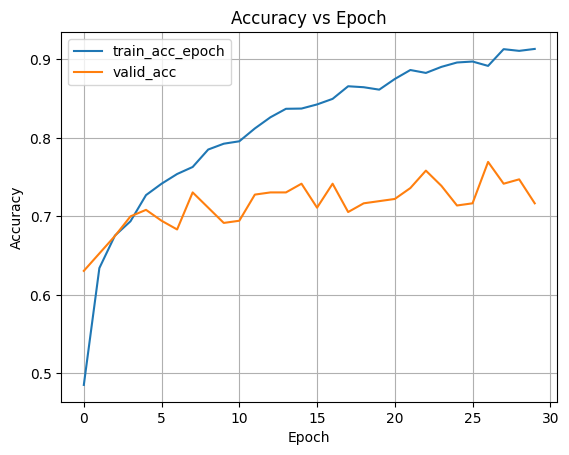

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Leer métricas del archivo CSV generado por el logger
metrics_path = f"{trainer.logger.log_dir}/metrics.csv"
metrics = pd.read_csv(metrics_path)

# Agregar métricas por época
aggreg_metrics = []
agg_col = "epoch"  # Agrupar por la columna de época
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())  # Calcular la media para todas las métricas por época
    agg[agg_col] = i
    aggreg_metrics.append(agg)

# Convertir a DataFrame para visualización
df_metrics = pd.DataFrame(aggreg_metrics)

# Graficar las pérdidas (loss) para entrenamiento y validación
df_metrics[["train_loss_epoch", "valid_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss", title="Loss vs Epoch"
)

# Graficar las precisiones (accuracy) para entrenamiento y validación
df_metrics[["train_acc_epoch", "valid_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Accuracy", title="Accuracy vs Epoch"
)

# Mostrar las gráficas
plt.show()


## Evaluamos el mejor modelo en el grupo de test

In [30]:
# Probar el modelo utilizando el mejor checkpoint guardado
trainer.test(
    model=lightning_model,
    datamodule=data_module,
    ckpt_path=callback_check.best_model_path  # Cargar el mejor modelo guardado automáticamente
)


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at ./logs/dog-emotion/version_0/checkpoints/best-checkpoint.ckpt


Entrenamiento: 3236, Validación: 360, Test: 400


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at ./logs/dog-emotion/version_0/checkpoints/best-checkpoint.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7599999904632568     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.7599999904632568}]

In [31]:
print(f"Mejor modelo guardado en: {callback_check.best_model_path}")


Mejor modelo guardado en: ./logs/dog-emotion/version_0/checkpoints/best-checkpoint.ckpt


In [32]:
df_metrics

,epoch,step,train_acc_epoch,train_acc_step,train_loss_epoch,train_loss_step,valid_acc,valid_loss
0,0,100.333333,0.485167,0.53125,1.168076,1.032197,0.630556,0.908110
1,1,201.666667,0.634116,0.68750,0.893359,0.815794,0.652778,0.850944
2,2,303.000000,0.675525,0.56250,0.809423,1.120781,0.675000,0.811808
3,3,404.333333,0.693758,0.62500,0.744885,0.873498,0.700000,0.806758
4,4,505.666667,0.727132,0.71875,0.697063,0.723580,0.708333,0.783786
5,5,607.000000,0.741656,0.71875,0.656270,0.623424,0.694444,0.763791
6,6,708.333333,0.754017,0.71875,0.622355,0.794682,0.683333,0.784677
7,7,809.666667,0.762979,0.62500,0.606035,0.995868,0.730556,0.729717
8,8,911.000000,0.785229,0.78125,0.554556,0.525870,0.711111,0.729846
9,9,1012.333333,0.792645,0.71875,0.522959,0.565363,0.691667,0.741496


In [33]:
import torch
import pandas as pd
import sqlite3

# Evaluar el modelo en el conjunto de prueba
trainer.test(model=lightning_model, datamodule=data_module, ckpt_path=callback_check.best_model_path)

# Obtener el dataloader de prueba
test_dataloader = data_module.test_dataloader()

# Listas para almacenar los resultados
predictions = []
labels = []

# Modo evaluación
lightning_model.eval()

# Deshabilitar el cálculo de gradientes para inferencia
with torch.no_grad():
    for batch in test_dataloader:
        inputs, targets = batch  # Obtener imágenes y etiquetas verdaderas

        outputs = lightning_model(inputs)  # Obtener predicciones del modelo

        _, predicted = torch.max(outputs, 1)  # Obtener la clase con mayor probabilidad

        predictions.extend(predicted.cpu().numpy())  # Guardar predicciones
        labels.extend(targets.cpu().numpy())  # Guardar etiquetas reales

# Crear un DataFrame con los resultados
df_results = pd.DataFrame({"Label": labels, "Prediction": predictions})



INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at ./logs/dog-emotion/version_0/checkpoints/best-checkpoint.ckpt


Entrenamiento: 3236, Validación: 360, Test: 400


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at ./logs/dog-emotion/version_0/checkpoints/best-checkpoint.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7599999904632568     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
df_results

In [ ]:
df_results.count()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(df_results["Label"], df_results["Prediction"])

# Crear el heatmap con la matriz de confusión
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=set(df_results["Label"]), yticklabels=set(df_results["Label"]))
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión")
plt.show()


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Mapeo de etiquetas numéricas a nombres de clases
label_to_class = {0: "angry", 1: "happy", 2: "relaxed", 3: "sad"}

# Mean y std de la normalización utilizada en los transform
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

# Inicializar listas para almacenar imágenes, etiquetas verdaderas y predichas
selected_images = {}
selected_true_labels = {}
selected_pred_labels = {}

# Buscar un batch con las 4 clases presentes
for inputs, targets in test_dataloader:
    # Modo evaluación del modelo
    lightning_model.eval()

    # Deshabilitar gradientes para inferencia
    with torch.no_grad():
        outputs = lightning_model(inputs)  # Obtener predicciones del modelo
        _, predicted = torch.max(outputs, 1)  # Obtener la clase con mayor probabilidad

    # Guardar una imagen de cada clase diferente
    for idx, label in enumerate(targets):
        label = label.item()
        if label not in selected_images:
            selected_images[label] = inputs[idx]  # Guardar la imagen
            selected_true_labels[label] = label_to_class[label]  # Etiqueta real
            selected_pred_labels[label] = label_to_class[predicted[idx].item()]  # Predicción del modelo

        # Detener si ya se encontraron las 4 clases
        if len(selected_images) == 4:
            break
    if len(selected_images) == 4:
        break

# Si no se encontraron todas las clases, lanzar un aviso
if len(selected_images) < 4:
    print("No se encontraron imágenes de todas las clases en el test set.")

# Crear la figura
fig, axes = plt.subplots(1, 4, figsize=(15, 6))

for i, (label, img) in enumerate(selected_images.items()):
    ax = axes[i]  # Seleccionar el subplot correspondiente

    # Convertir tensor a numpy y desnormalizar
    img = img.cpu().numpy().transpose(1, 2, 0)  # Convertir a formato (H, W, C)
    img = (img * imagenet_std) + imagenet_mean  # Desnormalizar
    img = np.clip(img, 0, 1)  # Asegurar que está en el rango [0,1]

    # Obtener etiquetas
    true_label_name = selected_true_labels[label]
    predicted_label_name = selected_pred_labels[label]

    # Mostrar la imagen con título
    ax.imshow(img)
    ax.set_title(f"True: {true_label_name}\nPred: {predicted_label_name}", fontsize=12)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [38]:
print(BATCH_SIZE)
print(NUM_EPOCHS)
print(LEARNING_RATE)
print(NUM_WORKERS)
print(CLASES)

16
30
0.0001
4
4


In [39]:
1+2

3